In [1]:
# Importing all relevant libraries and defining all constants

import uproot
import matplotlib.pyplot as plt
import numpy as np
import boost_histogram as bh
from numba import jit
from scipy.stats import norm
import matplotlib.mlab as mlab
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.optimize import curve_fit
import time as ti
from scipy.stats import sem



MEAN_FAIL_VALUE = 8415
STD_FAIL_VALUE = 5.5

PEAK_HEIGHT = 50
PEAK_SLOPE = 10


# Main Code

avg_background_value = 8400

# https://stackoverflow.com/questions/52782965/pythonic-way-to-determine-width-of-plot

print("Trying to open files ...")

# Viewing particular event of particular file.
# Open the data, apply to variable
file = "E:\Manchester_Uni\Physics_Year_4\MphysProject\Hecker\Run203-PMT107.root"
# file = "E:\Manchester_Uni\Physics_Year_4\MphysProject\Hecker\Boulby_107_Signal.root"

tree = uproot.open(file)["Tree;4"]
branches = tree.arrays()
# how long between data taken
timegate = 2
# length of event
eventlen = len(branches['ADC'][0])
time = []
# Creating list for sample times that are 2ns intervals, 150 samples
for i in range(eventlen):
    time.append(i*timegate)
# total_n_events = len(branches['ADC'])
total_n_events = 100000



time_arr = []
for i in range(total_n_events):
    time_arr.append(time)

time_arr = np.array(time_arr)


branch_arr = np.array(branches['ADC'])
branch_len = len(branch_arr)

print('Opened files')

# Input event
Nevent = 2
PEAK_BUFFER = 15

Trying to open files ...
Opened files


In [ ]:
# df = pd.read_hdf('E:\Manchester_Uni\Physics_Year_4\MphysProject\Hecker\Calibration\combined_calib_test.h5', key='test')

# # time_arr = []
# # for i in range(total_n_events):
# #     time_arr.append(time)

# # time_arr = np.array(time_arr)


# # branch_arr = np.array(branches['ADC'])
# # branch_len = len(branch_arr)


# # Input event
# Nevent = 6
# PEAK_BUFFER = 15

# x_arr = df['Time'].values


# y_arr = []

# for column in df.columns[1:]:
#     # extract the data of the column as a numpy array and append it to the list
#     y_arr.append(df[column].values)

# total_n_events = len(y_arr)
# # total_n_events = 1000

# print('Opened files')

In [2]:
# Function for peak finding

def peak_finding_func(data_x, data_y):
    signal_index_arr = []
    
    # Append 1 to this list, if any limits of the peak are reached
    delete_var = []
    
    # Finds the slope between two points and checks if it is negative
    # This is done to find the rough start of a peak
    
    def recursive_low_x(index):
        if (((data_y[index]-data_y[index-1])/(data_x[index]-data_x[index-1])) <= 0):
            idx = recursive_low_x(index-1)
        else:
            idx = index
        return idx
    
    # Recursively find peak point

    def peak_point(index):
        if index+1 >= 150:
            delete_var.append(1)
            return 150
        if ((((data_y[index]-data_y[index-1])/(data_x[index]-data_x[index-1])) <= 0) and 
            (((data_y[index+1]-data_y[index])/(data_x[index+1]-data_x[index])) >= 0)):
            peak_idx = index
        else:
            peak_idx = peak_point(index+1)
        return peak_idx
    
    # Recursively finds end of peak by checking slope again
    
    def recursive_high_x(index):
        if (((data_y[index+1]-data_y[index])/(data_x[index+1]-data_x[index])) >= 0):
            if index+1 >= 149:
                delete_var.append(1)
                return 150
            else:
                idx = recursive_high_x(index+1)
        else:
            idx = index+1
        return idx
    
    # Checks for a minimum slope and peak height in data and if found, sets the starting index to that
    # Otherwise the index was set to -1 and with this the event can be identified as background
    
    for i in range(len(data_x) - 1):
        if (abs((data_y[i+1]-data_y[i])/(data_x[i+1]-data_x[i])) > PEAK_SLOPE) and (abs(data_y[i+1] - data_y[i]) > PEAK_HEIGHT):
            index_var = i
            break
        else:
            index_var = -1
    
    if (index_var == -1):
        # Returns the signal index array, which is empty but does not delete the array from the data
        return signal_index_arr, []
    
    # Finds the peak with the previous functions and checks if the peak has to be deleted
    
    else:
        low_x_idx = recursive_low_x(index_var)
        peak_index_var = peak_point(index_var)
        if peak_index_var >= 149:
            delete_var.append(1)
            return signal_index_arr, delete_var
        high_x_idx = recursive_high_x(peak_index_var)
        signal_index_arr = np.arange(low_x_idx, high_x_idx)
        return signal_index_arr, delete_var

In [3]:
# Function for finding the threshold

def background_average_iter_func(data_x, data_y):
    mean_arr = []
    std_arr = []
    delete_arr = []
    for i in range(total_n_events):
        if (i == Nevent):
            bg_arr = []
            x = data_x
            y = data_y[i]
            plt.scatter(x,y, s=4)
            plt.xlabel("Sample Time (ns)", fontsize = 25)
            plt.ylabel("ADC Value", fontsize = 25)
            plt.xticks(fontsize=24)
            plt.yticks(fontsize=24)
            plt.title("Event " + str(i), fontsize = 30)
            signal_arr_indicies, delete_var = peak_finding_func(x, y)
            if len(delete_var) > 0:
                delete_arr.append(i)
            plt.plot(x[signal_arr_indicies], y[signal_arr_indicies], color='orange', label='Identified signal')
            plt.legend()
            plt.show()
            if (len(signal_arr_indicies) == 0):
                bg_arr.append(data_y[i])
            else:
                bg_arr.append(data_y[i][np.arange(0, (signal_arr_indicies[0] - PEAK_BUFFER))])
            bg_arr = np.array(bg_arr)
            bg_arr = [item for sublist in bg_arr for item in sublist]
            if (np.size(bg_arr) == 0):
                mean_arr.append(MEAN_FAIL_VALUE)
                std_arr.append(STD_FAIL_VALUE)
            else:
                mean_arr.append(np.mean(bg_arr))
                std_temp = np.std(bg_arr)
                std_arr.append(std_temp)
                std_error = sem(bg_arr)
                if ((std_error/std_temp)*100) > 20:
                    delete_arr.append(1)
        else:
            if (i % 100000 == 0):
                print(i)
            bg_arr = []
            signal_arr_indicies, delete_var = peak_finding_func(data_x, data_y[i])
            if len(delete_var) > 0:
                delete_arr.append(i)
            if (len(signal_arr_indicies) == 0):
                bg_arr.append(data_y[i])
            else:
                bg_arr.append(data_y[i][np.arange(0, (signal_arr_indicies[0] - PEAK_BUFFER))])
            bg_arr = np.array(bg_arr)
            bg_arr = [item for sublist in bg_arr for item in sublist]
            if (np.size(bg_arr) == 0):
                mean_arr.append(MEAN_FAIL_VALUE)
                std_arr.append(STD_FAIL_VALUE)
            else:
                # Find STD and mean and compare STD and STD error and reject events with more than 20% error
                mean_arr.append(np.mean(bg_arr))
                std_temp = np.std(bg_arr)
                std_arr.append(std_temp)
                std_error = sem(bg_arr)
                if (((std_error/std_temp)*100) > 20):
                    delete_arr.append(1)

    mean_arr = np.array(mean_arr)
    std_arr = np.array(std_arr)
    return mean_arr, std_arr, delete_arr

In [4]:
def bin_pos_func(x_min, x_max, n_bins, p_per_bin):
    bin_width = p_per_bin * 2
    bin_loc_arr = np.linspace(x_min + bin_width / 2, x_max - bin_width / 2, n_bins)
    return bin_loc_arr

def number_of_bins_func(x, p_per_bin):
    return (len(x) - len(x) % p_per_bin) // p_per_bin


def binned_data(y, n_bins, p_per_bin):
    y = y[:n_bins * p_per_bin]
    return np.sum(y.reshape(-1, p_per_bin), axis=1)

@jit
def start_idx_func(y, thres):
    for i in range(len(y)-2):
        if y[i] > thres:
            if y[i+1] > thres:
                if y[i+2] > thres:
                    if i != 0:
                        idx_start = i-1
                        break
                    else:
                        continue
    return idx_start

@jit
def end_idx_func(y, thres):
    for i in range(len(y)-2):
        if y[i] > thres:
            if y[i+1] > thres:
                if y[i+2] > thres:
                    if i != 0:
                        idx_start = i-1
                        break
                    else:
                        continue
    n_cut_idx = idx_start
    y = y[idx_start:]
    for i in range(len(y)-2):
        if y[i] < thres:
            if y[i+1] < thres:
                if y[i+2] < thres:
                    idx_end = i + n_cut_idx
                    break
            if i == len(y) - 1:
                idx_end = i + n_cut_idx
                if i+1 == len(y) - 1:
                    idx_end = i + n_cut_idx
                    if i+2 == len(y) - 1:
                        idx_end = i + n_cut_idx
    return idx_end

def area_calc(x, y):
    return np.sum(y*2)

In [5]:
# Check if two lines are intersecting using angle logic.

def ccw(A,B,C):
    return (C[1]-A[1]) * (B[0]-A[0]) > (B[1]-A[1]) * (C[0]-A[0])

# Return true if line segments AB and CD intersect
def intersect(A,B,C,D):
    return ccw(A,C,D) != ccw(B,C,D) and ccw(A,B,C) != ccw(A,B,D)

# This function finds the intersection point, if the lines do intersect

def find_intersection_point(x1,y1,x2,y2,x3,y3,x4,y4):
    
    if ((x1-x2)*(y3-y4)) == (y1-y2)*(x3-x4):
        return [-100,-100]
    
    px= ((x1*y2-y1*x2)*(x3-x4)-(x1-x2)*(x3*y4-y3*x4))/((x1-x2)*(y3-y4)-(y1-y2)*(x3-x4)) 
    py= ((x1*y2-y1*x2)*(y3-y4)-(y1-y2)*(x3*y4-y3*x4))/((x1-x2)*(y3-y4)-(y1-y2)*(x3-x4))
    
    return [px, py]


def fwhm_test_func_new(x_data, y_data):
    # Index of the point before intersection, so next point also needed
    if len(x_data) > 4:
        intersect_points_arr = []
        fwhm_asymptote = (np.max(y_data))/2
        A_line = np.array([x_data.min()-5,fwhm_asymptote])
        B_line = np.array([x_data.max()+5,fwhm_asymptote])
        for i in range(len(y_data)-1):
            C_data = np.array([x_data[i],y_data[i]])
            D_data = np.array([x_data[i+1],y_data[i+1]])
            if (intersect(A_line, B_line, C_data, D_data) == True):
                intersect_points_arr.append(find_intersection_point(A_line[0], A_line[1], B_line[0], B_line[1], C_data[0]
                                                                    , C_data[1], D_data[0], D_data[1]))
            else:
                continue
        try:
            if intersect_points_arr[1]:
                return np.array(intersect_points_arr)
        except IndexError:
            return np.array([[0, 0], [0, 0]])
    else:
        return np.array([[0, 0], [0, 0]])

In [6]:
def FWHM_func(x, y, start_idx, end_idx, pp_bin):
    
    if (end_idx - start_idx) < 5:
        return -20
    
    
    fwhm_asymptote = np.max(y)/2

    def find_first_intersect(idx):
        if (idx <= 0):
            return idx + 1
        if (idx >= end_idx):
            return idx - 1
        if (y[idx] > fwhm_asymptote):
            return idx
        else:
            return find_first_intersect(idx+1)

    def find_second_intersect(idx):
        if (idx <= 0):
            return idx + 1
        if (idx >= end_idx):
            return idx - 1
        if (y[idx] > fwhm_asymptote):
            return idx
        else:
            return find_second_intersect(idx-1)

    first_upper_idx = find_first_intersect(start_idx)
    second_upper_idx = find_second_intersect(end_idx)
    first_lower_idx = first_upper_idx-1
    second_lower_idx = second_upper_idx+1
    
    FWHM_left = find_intersection_point(x[first_lower_idx], y[first_lower_idx], x[first_upper_idx], y[first_upper_idx]
                                        , x[0], fwhm_asymptote, x[-1], fwhm_asymptote)
    FWHM_right = find_intersection_point(x[second_lower_idx], y[second_lower_idx], x[second_upper_idx], y[second_upper_idx]
                                         , x[0], fwhm_asymptote, x[-1], fwhm_asymptote)

    return FWHM_right[0] - FWHM_left[0]

0


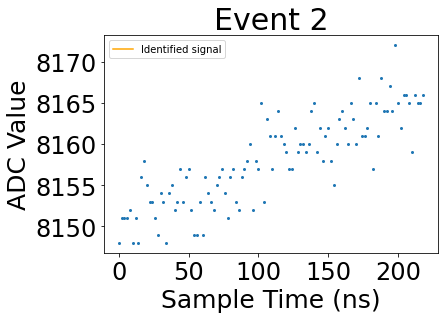

C:\Users\Marc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Marc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IndexError: index 110 is out of bounds for axis 0 with size 110

In [7]:
# Remove any data that is not acceptable

x_arr = np.array(time)
y_arr = branch_arr



mean_arr_temp, std_arr_0, delete_arr = background_average_iter_func(x_arr, y_arr)

y_arr = np.delete(y_arr, delete_arr, axis=0)


# Flip and centre data at y = 0

for i in range(total_n_events):
    y_arr[i] = (y_arr[i] - mean_arr_temp[i]) * -1

In [ ]:
# plt.plot(x_arr, y_arr[Nevent])
# plt.plot([np.min(x_arr), np.max(x_arr)], [std_arr_temp[Nevent], std_arr_temp[Nevent]], '--', color='red')
# plt.plot([np.min(x_arr), np.max(x_arr)], [0, 0], '--', color='black')
# plt.plot([np.min(x_arr), np.max(x_arr)], [-std_arr_temp[Nevent], -std_arr_temp[Nevent]], '--', color='red')
# plt.show()

bin_arr_2 = bin_pos_func(np.min(x_arr), np.max(x_arr), number_of_bins_func(x_arr, 2), 2)
bin_arr_3 = bin_pos_func(np.min(x_arr), np.max(x_arr), number_of_bins_func(x_arr, 3), 3)
bin_arr_4 = bin_pos_func(np.min(x_arr), np.max(x_arr), number_of_bins_func(x_arr, 4), 4)
bin_arr_5 = bin_pos_func(np.min(x_arr), np.max(x_arr), number_of_bins_func(x_arr, 5), 5)
bin_arr_6 = bin_pos_func(np.min(x_arr), np.max(x_arr), number_of_bins_func(x_arr, 6), 6)
bin_arr_7 = bin_pos_func(np.min(x_arr), np.max(x_arr), number_of_bins_func(x_arr, 7), 7)
bin_arr_8 = bin_pos_func(np.min(x_arr), np.max(x_arr), number_of_bins_func(x_arr, 8), 8)

binned_adc_2 = [[]]
binned_adc_3 = [[]]
binned_adc_4 = [[]]
binned_adc_5 = [[]]
binned_adc_6 = [[]]
binned_adc_7 = [[]]
binned_adc_8 = [[]]


for i in range(total_n_events):
    binned_adc_2.append(binned_data(y_arr[i], number_of_bins_func(x_arr, 2), 2))
    binned_adc_3.append(binned_data(y_arr[i], number_of_bins_func(x_arr, 3), 3))
    binned_adc_4.append(binned_data(y_arr[i], number_of_bins_func(x_arr, 4), 4))
    binned_adc_5.append(binned_data(y_arr[i], number_of_bins_func(x_arr, 5), 5))
    binned_adc_6.append(binned_data(y_arr[i], number_of_bins_func(x_arr, 6), 6))
    binned_adc_7.append(binned_data(y_arr[i], number_of_bins_func(x_arr, 7), 7))
    binned_adc_8.append(binned_data(y_arr[i], number_of_bins_func(x_arr, 8), 8))

binned_adc_2 = np.array(binned_adc_2[1:])
binned_adc_3 = np.array(binned_adc_3[1:])
binned_adc_4 = np.array(binned_adc_4[1:])
binned_adc_5 = np.array(binned_adc_5[1:])
binned_adc_6 = np.array(binned_adc_6[1:])
binned_adc_7 = np.array(binned_adc_7[1:])
binned_adc_8 = np.array(binned_adc_8[1:])


std_arr_2 = []
std_arr_3 = []
std_arr_4 = []
std_arr_5 = []
std_arr_6 = []
std_arr_7 = []
std_arr_8 = []

for i in range(total_n_events):
    std_arr_2.append(np.sqrt(2) * std_arr_0[i])
    std_arr_3.append(np.sqrt(3) * std_arr_0[i])
    std_arr_4.append(np.sqrt(4) * std_arr_0[i])
    std_arr_5.append(np.sqrt(5) * std_arr_0[i])
    std_arr_6.append(np.sqrt(6) * std_arr_0[i])
    std_arr_7.append(np.sqrt(7) * std_arr_0[i])
    std_arr_8.append(np.sqrt(8) * std_arr_0[i])


std_arr_2 = np.array(std_arr_2)
std_arr_3 = np.array(std_arr_3)
std_arr_4 = np.array(std_arr_4)
std_arr_5 = np.array(std_arr_5)
std_arr_6 = np.array(std_arr_6)
std_arr_7 = np.array(std_arr_7)
std_arr_8 = np.array(std_arr_8)

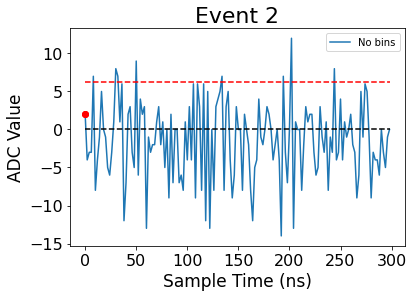

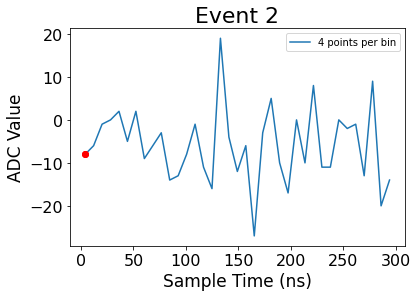

In [ ]:
# plt.plot(x_arr, y_arr[Nevent], label='No bins')
# plt.plot(bin_arr_2, binned_adc_2, label='2 points per bin')
# plt.plot(bin_arr_3, binned_adc_3, label='3 points per bin')
# plt.plot(bin_arr_4, binned_adc_4, label='4 points per bin')
# plt.plot(bin_arr_5, binned_adc_5, label='5 points per bin')
# plt.plot(bin_arr_6, binned_adc_6, label='6 points per bin')
# plt.legend()
# plt.show()

starting_index_bin_0 = []
starting_index_bin_2 = []
starting_index_bin_3 = []
starting_index_bin_4 = []
starting_index_bin_5 = []
starting_index_bin_6 = []
starting_index_bin_7 = []
starting_index_bin_8 = []

ending_index_bin_0 = []
ending_index_bin_2 = []
ending_index_bin_3 = []
ending_index_bin_4 = []
ending_index_bin_5 = []
ending_index_bin_6 = []
ending_index_bin_7 = []
ending_index_bin_8 = []


for i in range(total_n_events):
    starting_index_bin_0.append(start_idx_func(y_arr[i], std_arr_0[i]))
    ending_index_bin_0.append(end_idx_func(y_arr[i], std_arr_0[i]))
    starting_index_bin_2.append(start_idx_func(binned_adc_2[i], std_arr_2[i]))
    ending_index_bin_2.append(end_idx_func(binned_adc_2[i], std_arr_2[i]))
    starting_index_bin_3.append(start_idx_func(binned_adc_3[i], std_arr_3[i]))
    ending_index_bin_3.append(end_idx_func(binned_adc_3[i], std_arr_3[i]))
    starting_index_bin_4.append(start_idx_func(binned_adc_4[i], std_arr_4[i]))
    ending_index_bin_4.append(end_idx_func(binned_adc_4[i], std_arr_4[i]))
    starting_index_bin_5.append(start_idx_func(binned_adc_5[i], std_arr_5[i]))
    ending_index_bin_5.append(end_idx_func(binned_adc_5[i], std_arr_5[i]))
    starting_index_bin_6.append(start_idx_func(binned_adc_6[i], std_arr_6[i]))
    ending_index_bin_6.append(end_idx_func(binned_adc_6[i], std_arr_6[i]))
    starting_index_bin_7.append(start_idx_func(binned_adc_7[i], std_arr_7[i]))
    ending_index_bin_7.append(end_idx_func(binned_adc_7[i], std_arr_7[i]))
    starting_index_bin_8.append(start_idx_func(binned_adc_8[i], std_arr_8[i]))
    ending_index_bin_8.append(end_idx_func(binned_adc_8[i], std_arr_8[i]))



starting_index_bin_0 = np.array(starting_index_bin_0)
starting_index_bin_2 = np.array(starting_index_bin_2)
starting_index_bin_3 = np.array(starting_index_bin_3)
starting_index_bin_4 = np.array(starting_index_bin_4)
starting_index_bin_5 = np.array(starting_index_bin_5)
starting_index_bin_6 = np.array(starting_index_bin_6)
starting_index_bin_7 = np.array(starting_index_bin_7)
starting_index_bin_8 = np.array(starting_index_bin_8)

ending_index_bin_0 = np.array(ending_index_bin_0)
ending_index_bin_2 = np.array(ending_index_bin_2)
ending_index_bin_3 = np.array(ending_index_bin_3)
ending_index_bin_4 = np.array(ending_index_bin_4)
ending_index_bin_5 = np.array(ending_index_bin_5)
ending_index_bin_6 = np.array(ending_index_bin_6)
ending_index_bin_7 = np.array(ending_index_bin_7)
ending_index_bin_8 = np.array(ending_index_bin_8)

plt.plot(x_arr, y_arr[Nevent], label='No bins')
plt.plot(x_arr[starting_index_bin_0[Nevent]], y_arr[Nevent][starting_index_bin_0[Nevent]], 'ro')
plt.plot(x_arr[ending_index_bin_0[Nevent]], y_arr[Nevent][ending_index_bin_0[Nevent]], 'ro')
plt.plot([np.min(x_arr), np.max(x_arr)], [std_arr_0[Nevent], std_arr_0[Nevent]], '--', color='red')
plt.plot([np.min(x_arr), np.max(x_arr)], [0, 0], '--', color='black')
plt.xlabel("Sample Time (ns)", fontsize = 17)
plt.ylabel("ADC Value", fontsize = 17)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("Event " + str(Nevent), fontsize = 22)
plt.legend()
plt.show()

# plt.plot(bin_arr_2, binned_adc_2[Nevent], label='No bins')
# plt.plot(bin_arr_2[starting_index_bin_2[Nevent]], binned_adc_2[starting_index_bin_2[Nevent]], 'ro')
# plt.plot(bin_arr_2[ending_index_bin_2[Nevent]], binned_adc_2[ending_index_bin_2[Nevent]], 'ro')
# plt.plot([np.min(x_arr), np.max(x_arr)], [std_arr_0[Nevent], std_arr_0[Nevent]], '--', color='black')
# plt.plot([np.min(x_arr), np.max(x_arr)], [std_arr_2[Nevent], std_arr_2[Nevent]], '--', color='blue')
# plt.show()

bin_area_0 = []
bin_area_2 = []
bin_area_3 = []
bin_area_4 = []
bin_area_5 = []
bin_area_6 = []
bin_area_7 = []
bin_area_8 = []

for i in range(total_n_events):
    bin_area_0.append(area_calc(x_arr[starting_index_bin_0[i]:ending_index_bin_0[i]]
                                , y_arr[i][starting_index_bin_0[i]:ending_index_bin_0[i]]))
    bin_area_2.append(area_calc(bin_arr_2[starting_index_bin_2[i]:ending_index_bin_2[i]]
                                , binned_adc_2[i][starting_index_bin_2[i]:ending_index_bin_2[i]]))
    bin_area_3.append(area_calc(bin_arr_3[starting_index_bin_3[i]:ending_index_bin_3[i]]
                                , binned_adc_3[i][starting_index_bin_3[i]:ending_index_bin_3[i]]))
    bin_area_4.append(area_calc(bin_arr_4[starting_index_bin_4[i]:ending_index_bin_4[i]]
                                , binned_adc_4[i][starting_index_bin_4[i]:ending_index_bin_4[i]]))
    bin_area_5.append(area_calc(bin_arr_5[starting_index_bin_5[i]:ending_index_bin_5[i]]
                                , binned_adc_5[i][starting_index_bin_5[i]:ending_index_bin_5[i]]))
    bin_area_6.append(area_calc(bin_arr_6[starting_index_bin_6[i]:ending_index_bin_6[i]]
                                , binned_adc_6[i][starting_index_bin_6[i]:ending_index_bin_6[i]]))
    bin_area_7.append(area_calc(bin_arr_7[starting_index_bin_7[i]:ending_index_bin_7[i]]
                                , binned_adc_7[i][starting_index_bin_7[i]:ending_index_bin_7[i]]))
    bin_area_8.append(area_calc(bin_arr_8[starting_index_bin_8[i]:ending_index_bin_8[i]]
                                , binned_adc_8[i][starting_index_bin_8[i]:ending_index_bin_8[i]]))




plt.plot(bin_arr_4, binned_adc_4[Nevent], label='4 points per bin')
plt.plot(bin_arr_4[starting_index_bin_4[Nevent]], binned_adc_4[Nevent][starting_index_bin_4[Nevent]], 'ro')
plt.plot(bin_arr_4[ending_index_bin_4[Nevent]], binned_adc_4[Nevent][ending_index_bin_4[Nevent]], 'ro')
plt.xlabel("Sample Time (ns)", fontsize = 17)
plt.ylabel("ADC Value", fontsize = 17)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("Event " + str(Nevent), fontsize = 22)
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


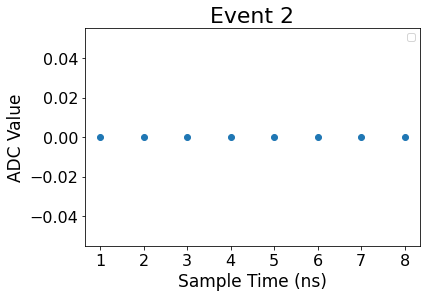

In [ ]:
# plt.plot(bin_arr_8, binned_adc_8[Nevent], label='8 points per bin')
# plt.plot(bin_arr_8[starting_index_bin_8[Nevent]], binned_adc_8[Nevent][starting_index_bin_8[Nevent]], 'ro')
# plt.plot(bin_arr_8[ending_index_bin_8[Nevent]], binned_adc_8[Nevent][ending_index_bin_8[Nevent]], 'ro')
# plt.xlabel("Sample Time (ns)", fontsize = 17)
# plt.ylabel("ADC Value", fontsize = 17)
# plt.xticks(fontsize=16)
# plt.yticks(fontsize=16)
# plt.title("Event " + str(Nevent), fontsize = 22)
# plt.legend()
# plt.show()




bin_area_0 = np.array(bin_area_0)
bin_area_2 = np.array(bin_area_2)
bin_area_3 = np.array(bin_area_3)
bin_area_4 = np.array(bin_area_4)
bin_area_5 = np.array(bin_area_5)
bin_area_6 = np.array(bin_area_6)
bin_area_7 = np.array(bin_area_7)
bin_area_8 = np.array(bin_area_8)


p_per_bin_arr = [1, 2, 3, 4, 5, 6, 7, 8]
area_arr = [bin_area_0[Nevent], bin_area_2[Nevent], bin_area_3[Nevent], bin_area_4[Nevent], bin_area_5[Nevent]
            , bin_area_6[Nevent], bin_area_7[Nevent], bin_area_8[Nevent]]

# p_per_bin_arr = [1, 2, 3, 4, 6]
# area_arr = [bin_area_0[Nevent], bin_area_2[Nevent], bin_area_3[Nevent], bin_area_4[Nevent], bin_area_6[Nevent]]


plt.scatter(p_per_bin_arr, area_arr)
plt.xlabel("Sample Time (ns)", fontsize = 17)
plt.ylabel("ADC Value", fontsize = 17)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("Event " + str(Nevent), fontsize = 22)
plt.legend()
plt.show()


In [ ]:
# print('Before Intersection')

# start_old_time = ti.time()

# intersec_point_arr_0 = []
# intersec_point_arr_2 = []
# intersec_point_arr_3 = []
# intersec_point_arr_4 = []
# intersec_point_arr_5 = []
# intersec_point_arr_6 = []
# intersec_point_arr_7 = []
# intersec_point_arr_8 = []


# for i in range(total_n_events):
#     intersec_point_arr_0.append(fwhm_test_func_new(x_arr[starting_index_bin_0[i]:ending_index_bin_0[i]]
#                                                  , y_arr[i][starting_index_bin_0[i]:ending_index_bin_0[i]]))
#     intersec_point_arr_2.append(fwhm_test_func_new(bin_arr_2[starting_index_bin_2[i]:ending_index_bin_2[i]]
#                                                  , binned_adc_2[i][starting_index_bin_2[i]:ending_index_bin_2[i]]))
#     intersec_point_arr_3.append(fwhm_test_func_new(bin_arr_3[starting_index_bin_3[i]:ending_index_bin_3[i]]
#                                                  , binned_adc_3[i][starting_index_bin_3[i]:ending_index_bin_3[i]]))
#     intersec_point_arr_4.append(fwhm_test_func_new(bin_arr_4[starting_index_bin_4[i]:ending_index_bin_4[i]]
#                                                  , binned_adc_4[i][starting_index_bin_4[i]:ending_index_bin_4[i]]))
#     intersec_point_arr_5.append(fwhm_test_func_new(bin_arr_5[starting_index_bin_5[i]:ending_index_bin_5[i]]
#                                                  , binned_adc_5[i][starting_index_bin_5[i]:ending_index_bin_5[i]]))
#     intersec_point_arr_6.append(fwhm_test_func_new(bin_arr_6[starting_index_bin_6[i]:ending_index_bin_6[i]]
#                                                  , binned_adc_6[i][starting_index_bin_6[i]:ending_index_bin_6[i]]))
#     intersec_point_arr_7.append(fwhm_test_func_new(bin_arr_7[starting_index_bin_7[i]:ending_index_bin_7[i]]
#                                                  , binned_adc_7[i][starting_index_bin_7[i]:ending_index_bin_7[i]]))
#     intersec_point_arr_8.append(fwhm_test_func_new(bin_arr_8[starting_index_bin_8[i]:ending_index_bin_8[i]]
#                                                  , binned_adc_8[i][starting_index_bin_8[i]:ending_index_bin_8[i]]))




# intersec_point_arr_0 = np.array(intersec_point_arr_0, dtype=object)
# intersec_point_arr_2 = np.array(intersec_point_arr_2, dtype=object)
# intersec_point_arr_3 = np.array(intersec_point_arr_3, dtype=object)
# intersec_point_arr_4 = np.array(intersec_point_arr_4, dtype=object)
# intersec_point_arr_5 = np.array(intersec_point_arr_5, dtype=object)
# intersec_point_arr_6 = np.array(intersec_point_arr_6, dtype=object)
# intersec_point_arr_7 = np.array(intersec_point_arr_7, dtype=object)
# intersec_point_arr_8 = np.array(intersec_point_arr_8, dtype=object)


# fwhm_arr_0 = []
# fwhm_arr_2 = []
# fwhm_arr_3 = []
# fwhm_arr_4 = []
# fwhm_arr_5 = []
# fwhm_arr_6 = []
# fwhm_arr_7 = []
# fwhm_arr_8 = []

# print('Before FWHM')

# for i in range(total_n_events):
#     fwhm_arr_0.append(np.abs(intersec_point_arr_0[i][0][0] - intersec_point_arr_0[i][1][0]))
#     fwhm_arr_2.append(np.abs(intersec_point_arr_2[i][0][0] - intersec_point_arr_2[i][1][0]))
#     fwhm_arr_3.append(np.abs(intersec_point_arr_3[i][0][0] - intersec_point_arr_3[i][1][0]))
#     fwhm_arr_4.append(np.abs(intersec_point_arr_4[i][0][0] - intersec_point_arr_4[i][1][0]))
#     fwhm_arr_5.append(np.abs(intersec_point_arr_5[i][0][0] - intersec_point_arr_5[i][1][0]))
#     fwhm_arr_6.append(np.abs(intersec_point_arr_6[i][0][0] - intersec_point_arr_6[i][1][0]))
#     fwhm_arr_7.append(np.abs(intersec_point_arr_7[i][0][0] - intersec_point_arr_7[i][1][0]))
#     fwhm_arr_8.append(np.abs(intersec_point_arr_8[i][0][0] - intersec_point_arr_8[i][1][0]))

# fwhm_arr_0 = np.array(fwhm_arr_0)
# fwhm_arr_2 = np.array(fwhm_arr_2)
# fwhm_arr_3 = np.array(fwhm_arr_3)
# fwhm_arr_4 = np.array(fwhm_arr_4)
# fwhm_arr_5 = np.array(fwhm_arr_5)
# fwhm_arr_6 = np.array(fwhm_arr_6)
# fwhm_arr_7 = np.array(fwhm_arr_7)
# fwhm_arr_8 = np.array(fwhm_arr_8)




# end_old_time = ti.time()

Before FWHM


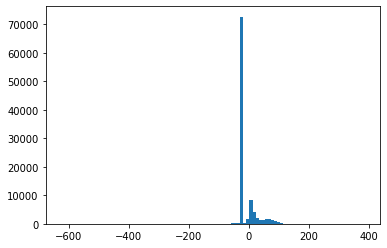

In [ ]:
print('Before FWHM')

fwhm_arr_0 = []
fwhm_arr_2 = []
fwhm_arr_3 = []
fwhm_arr_4 = []
fwhm_arr_5 = []
fwhm_arr_6 = []
fwhm_arr_7 = []
fwhm_arr_8 = []

for i in range(total_n_events):
    fwhm_arr_0.append(FWHM_func(x_arr, y_arr[i], starting_index_bin_0[i], ending_index_bin_0[i], 1))
    fwhm_arr_2.append(FWHM_func(bin_arr_2, binned_adc_2[i], starting_index_bin_2[i], ending_index_bin_2[i], 2))
    fwhm_arr_3.append(FWHM_func(bin_arr_3, binned_adc_3[i], starting_index_bin_3[i], ending_index_bin_3[i], 3))
    fwhm_arr_4.append(FWHM_func(bin_arr_4, binned_adc_4[i], starting_index_bin_4[i], ending_index_bin_4[i], 4))
    fwhm_arr_5.append(FWHM_func(bin_arr_5, binned_adc_5[i], starting_index_bin_5[i], ending_index_bin_5[i], 5))
    fwhm_arr_6.append(FWHM_func(bin_arr_6, binned_adc_6[i], starting_index_bin_6[i], ending_index_bin_6[i], 6))
    fwhm_arr_7.append(FWHM_func(bin_arr_7, binned_adc_7[i], starting_index_bin_7[i], ending_index_bin_7[i], 7))
    fwhm_arr_8.append(FWHM_func(bin_arr_8, binned_adc_8[i], starting_index_bin_8[i], ending_index_bin_8[i], 8))

fwhm_arr_0 = np.array(fwhm_arr_0)
fwhm_arr_2 = np.array(fwhm_arr_2)
fwhm_arr_3 = np.array(fwhm_arr_3)
fwhm_arr_4 = np.array(fwhm_arr_4)
fwhm_arr_5 = np.array(fwhm_arr_5)
fwhm_arr_6 = np.array(fwhm_arr_6)
fwhm_arr_7 = np.array(fwhm_arr_7)
fwhm_arr_8 = np.array(fwhm_arr_8)



plt.hist(fwhm_arr_0, bins=100)
plt.show()

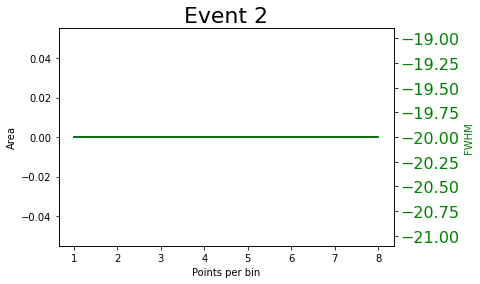

In [ ]:



# Define data

x_axis_arr = [1, 2, 3, 4, 5, 6, 7, 8]
y_area_arr = [bin_area_0[Nevent], bin_area_2[Nevent], bin_area_3[Nevent], bin_area_4[Nevent], bin_area_5[Nevent], bin_area_6[Nevent], bin_area_7[Nevent], bin_area_7[Nevent]]
y_fwhm_arr = [fwhm_arr_0[Nevent], fwhm_arr_2[Nevent], fwhm_arr_3[Nevent], fwhm_arr_4[Nevent], fwhm_arr_5[Nevent], fwhm_arr_6[Nevent], fwhm_arr_7[Nevent], fwhm_arr_8[Nevent]]



# Create Plot

fig, ax1 = plt.subplots() 


  
ax1.set_xlabel('Points per bin') 
ax1.set_ylabel('Area', color = 'black') 
plot_1 = ax1.plot(x_axis_arr, y_area_arr, color = 'black') 
ax1.tick_params(axis ='y', labelcolor = 'black') 

# Adding Twin Axes

ax2 = ax1.twinx() 
  
ax2.set_ylabel('FWHM', color = 'green') 
plot_2 = ax2.plot(x_axis_arr, y_fwhm_arr, color = 'green') 
ax2.tick_params(axis ='y', labelcolor = 'green') 

# Show plot

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("Event " + str(Nevent), fontsize = 22)

plt.show()


# adc_values_photo_peak_arr = []

# for i in range(total_n_events):
#     # if (fwhm_arr_0[i] > 5) and (fwhm_arr_0[i] < 10):
#         adc_values_photo_peak_arr.append(y_arr[i])


# adc_values_photo_peak_arr = np.array(adc_values_photo_peak_arr)
# print(adc_values_photo_peak_arr)

# plt.hist(adc_values_photo_peak_arr)
# plt.xlabel("Sample Time (ns)", fontsize = 17)
# plt.ylabel("ADC Value", fontsize = 17)
# plt.xticks(fontsize=16)
# plt.yticks(fontsize=16)
# plt.title("Event " + str(Nevent), fontsize = 22)
# plt.legend()
# plt.show()



# def _flatten(values):
#     if isinstance(values, np.ndarray):
#         yield values.flatten()
#     else:
#         for value in values:
#             yield from _flatten(value)

# def flatten(values):
#     # flatten nested lists of np.ndarray to np.ndarray
#     return np.concatenate(list(_flatten(values)))

# adc_values_photo_peak_arr = []

# for i in range(total_n_events):
#     if fwhm_arr_0[i] > 5:
#         adc_values_photo_peak_arr.append(y_arr[i][starting_index_bin_0[i]:ending_index_bin_0[i]])


# adc_values_photo_peak_arr = flatten(adc_values_photo_peak_arr)

# adc_values_photo_peak_arr = [i for i in adc_values_photo_peak_arr if i < 200]

# adc_values_photo_peak_arr = np.array(adc_values_photo_peak_arr)


# plt.hist(adc_values_photo_peak_arr, bins=500)
# plt.show()



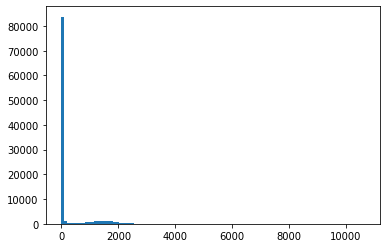

Here


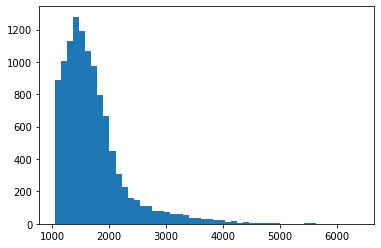

In [ ]:




adc_values_photo_peak_arr = []

for i in range(total_n_events):
    # if fwhm_arr_2[i] > 0:
    adc_values_photo_peak_arr.append(np.sum(binned_adc_2[i][starting_index_bin_2[i]:ending_index_bin_2[i]]))



adc_values_photo_peak_arr = np.array(adc_values_photo_peak_arr)
n, bin_edges, patches = plt.hist(adc_values_photo_peak_arr, bins=100)
plt.show()

print('Here')

bins_centres = np.array([0.5 * (bin_edges[i] + bin_edges[i+1]) for i in range(len(bin_edges)-1)])

plt.bar(bins_centres[10:60], n[10:60], width=(bin_edges[1] - bin_edges[0]))
plt.show()





[1180.62149323 1449.23374494  443.91723573   22.14145454]
[14.25920903  8.8355667   9.70265248  4.89500897]


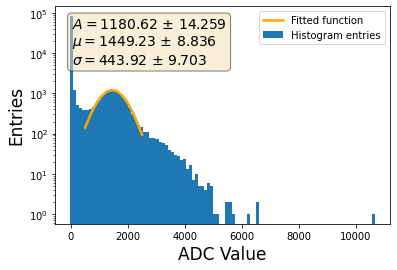

226442772.64713237


In [ ]:


def gauss(x, A, x0, sigma, H):
    return (A * np.exp(- (((x - x0)**2))/(2 * (sigma**2)))) + H




popt, pcov = curve_fit(gauss, xdata=bins_centres[10:60], ydata=n[10:60], p0=[6000, 1450, 460, 3000])
print(popt)
perr = np.sqrt(np.diag(pcov))
print(perr)

xspace = np.linspace(500, 2500, 100000)



fig, ax = plt.subplots()

ax.bar(bins_centres, n, width=(bin_edges[1] - bin_edges[0]), label=r'Histogram entries')
ax.plot(xspace, gauss(xspace, *popt), color='orange', linewidth=2.5, label=r'Fitted function')

ax.set_xlabel("ADC Value", fontsize = 17)
ax.set_ylabel("Entries", fontsize = 17)
# ax.set_xticks(fontsize=16)
# ax.set_yticks(fontsize=16)

textstr = '\n'.join((
    r'$A=%.2f$ $\pm~%.3f$' % (popt[0], perr[0], ),
    r'$\mu=%.2f$ $\pm~%.3f$' % (popt[1], perr[1], ),
    r'$\sigma=%.2f$ $\pm~%.3f$' % (popt[2], perr[2], )))

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.set_yscale("log")

# ax.title(r'$A = %.3f\  \mu = %.3f\  \sigma = %.3f$' %(popt[0],popt[1],popt[2]), fontsize = 22)
ax.legend()
plt.show()


G = (popt[1]* 25 * 10**(-15))/(1.6*10**(-19))
print(G)

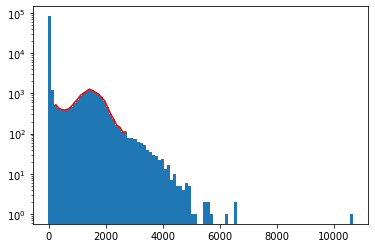

In [ ]:
fig, ax = plt.subplots()

ax.bar(bins_centres, n, width=(bin_edges[1] - bin_edges[0]), label=r'Histogram entries')
ax.plot(bins_centres[2:26], n[2:26], c='r')
ax.set_yscale("log")
plt.show()

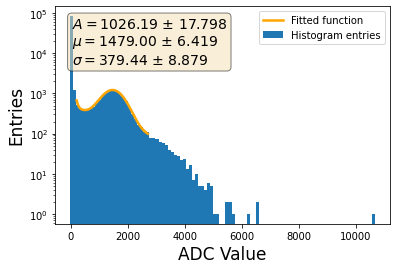

In [ ]:
x_fitting_data = bins_centres[1:26]
y_fitting_data = n[1:26]

def combined_func(x, amplitude_gaussian, mean_gaussian, sigma_gaussian,amplitude_exp1, decay_exp1,amplitude_exp2, decay_exp2):
    return (amplitude_gaussian * np.exp(-((x - mean_gaussian) ** 2) / (2 * (sigma_gaussian ** 2))) + amplitude_exp1 * np.exp(-x / decay_exp1) 
            + amplitude_exp2 * np.exp(-x / decay_exp2))

def fit_gauss_2exps(x, y, p0):
    popt, pcov = curve_fit(combined_func, x, y, p0)
    return popt, pcov

guess = [1200, 1450, 421, 980, 445, 400, 10]

popt, pcov = fit_gauss_2exps(x_fitting_data, y_fitting_data, guess)


perr = np.sqrt(np.diag(pcov))





xspace = np.linspace(200, 2700, 100000)

fig, ax = plt.subplots()

ax.bar(bins_centres, n, width=(bin_edges[1] - bin_edges[0]), label=r'Histogram entries')
ax.plot(xspace, combined_func(xspace, *popt), color='orange', linewidth=2.5, label=r'Fitted function')

ax.set_xlabel("ADC Value", fontsize = 17)
ax.set_ylabel("Entries", fontsize = 17)


textstr = '\n'.join((
    r'$A=%.2f$ $\pm~%.3f$' % (popt[0], perr[0], ),
    r'$\mu=%.2f$ $\pm~%.3f$' % (popt[1], perr[1], ),
    r'$\sigma=%.2f$ $\pm~%.3f$' % (popt[2], perr[2], )))

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.set_yscale("log")
ax.legend()
plt.show()

In [ ]:
# Gain calculation

G = (popt[1]* 25 * 10**(-15))/(1.6*10**(-19))
print('%.2E' % G)



2.31E+08


In [ ]:
print('Finished')

Finished
